# Лабораторная работа № 4.

## Сети с радиальными базисными элементами

Целью работы является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации иаппроксимации функции.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras as keras
from keras import backend as backend

### Задание 1

Вспомогательные константы

In [2]:
BATCH = 5
EPOCHES = 500
EPS = 1e-6
N = 100
M = 3

Уравнение эллипса в параметрическом виде и поворот точек на угол phi

In [3]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

def rotate(x, y, phi):
    xr = x * np.cos(phi) - y * np.sin(phi)
    yr = x * np.sin(phi) + y * np.cos(phi)
    return xr, yr

In [4]:
a = [0.4, 0.7, 1.0]
b = [0.15, 0.5, 1.0]
alpha = [np.pi / 6, -np.pi / 3, 0]
x0 = [-0.1, 0, 0]
y0 = [0.15, 0, 0]

Подготовка обучающих данных

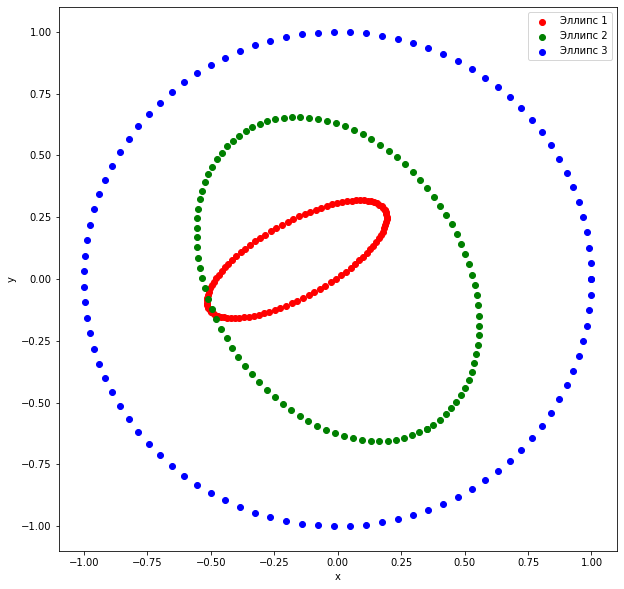

In [5]:
t = np.linspace(0, 2 * np.pi, N)

train_x = np.empty([0, 2])
train_y = np.empty([0, M])

clrs = ["r", "g", "b"]
lbls = ["Эллипс 1", "Эллипс 2", "Эллипс 3"]
figure = plt.figure(figsize = (10, 10))

for i in range(M):
    xe, ye = ellipse(t, a[i], b[i], x0[i], y0[i])
    xr, yr = rotate(xe, ye, alpha[i])
    plt.scatter(xr, yr, color = clrs[i], label = lbls[i])
    fig_x = np.array(list(zip(xr, yr)))
    train_x = np.concatenate((train_x, fig_x), axis = 0)
    fig_y = np.full([N, M], EPS)
    for j in range(N):
        fig_y[j][i] = 1.0 - fig_y[j][i]
    train_y = np.concatenate((train_y, fig_y), axis = 0)

plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

Описание слоя с радиальными базисными элементами

In [6]:
class RBFLayer(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBFLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.mu = self.add_weight(name = "mu",
                                  shape = (input_shape[1], self.output_dim),
                                  initializer = tf.keras.initializers.RandomUniform(minval = -1, maxval = 1),
                                  trainable = True)
        self.sigma = self.add_weight(name = "sigma",
                                     shape = (self.output_dim,),
                                     initializer = "random_normal",
                                     trainable = True)
        super(RBFLayer, self).build(input_shape)
    
    def call(self, inputs):
        diff = backend.expand_dims(inputs) - self.mu
        output = backend.exp(backend.sum(diff ** 2, axis = 1) * self.sigma)
        return output

Построение и обучение модели

In [7]:
model = tf.keras.models.Sequential([
    RBFLayer(32, input_shape = (2,), name = "rbf_layer"),
    tf.keras.layers.Dense(M, activation = "sigmoid", name = "dense")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 32)                96        
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "mse",
    metrics = ["mae"]
)

hst = model.fit(x = train_x, y = train_y, batch_size = BATCH, epochs = EPOCHES, verbose = False, shuffle = True)

Визуализация результата

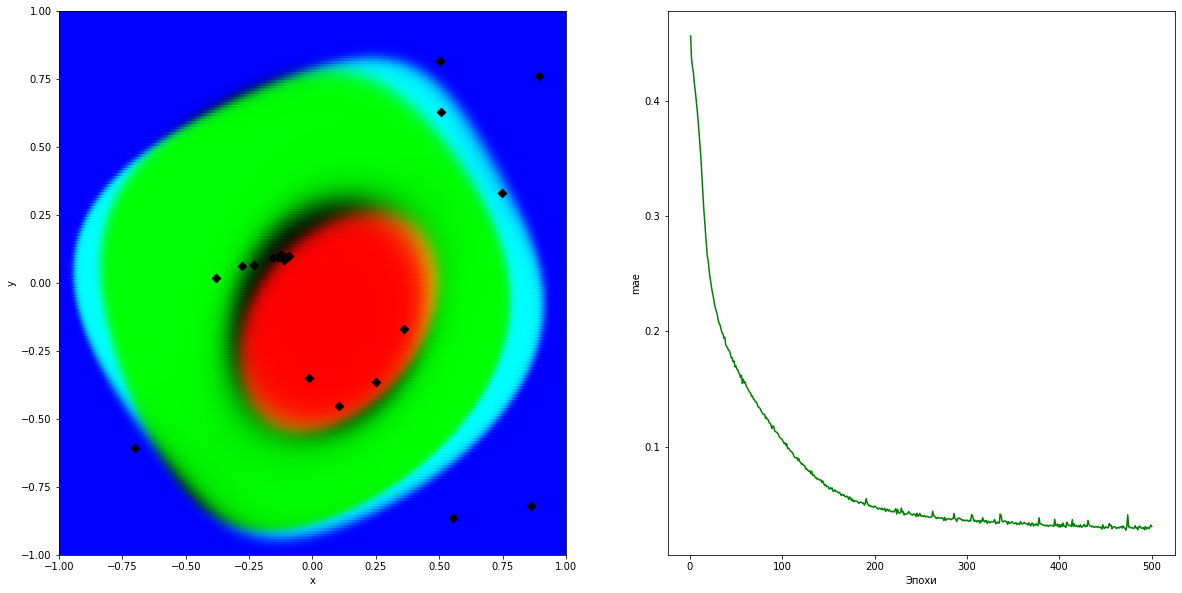

In [9]:
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)

mx, my = np.meshgrid(x, y)
xy = np.array(list(itertools.product(x, y)))

figure = plt.figure(figsize = (20, 10))
axes = figure.add_subplot(121)
pred = model.predict(xy, verbose = False)
plt.scatter(mx, my, c = pred)
mu = model.get_layer("rbf_layer").get_weights()[0]
plt.scatter(mu[0], mu[1], color = "black", marker = "D")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.ylabel("y")
plt.xlabel("x")

axes = figure.add_subplot(122)
epticks = [(i + 1) for i in range(len(hst.history["mae"]))]
plt.plot(epticks, hst.history["mae"], "g")
plt.ylabel("mae")
plt.xlabel("Эпохи")

plt.show()

### Задание 2

In [10]:
def x(t):
    return np.sin(np.sin(t) * t * t + 5 * t)

Подготовка обучающих данных

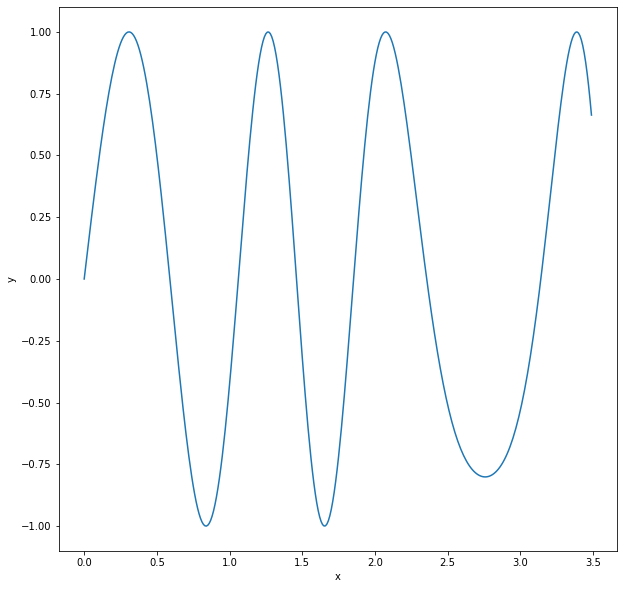

In [11]:
h = 0.01

train_x = np.arange(0, 3.5, h)
train_y = x(train_x)

figure = plt.figure(figsize = (10, 10))
plt.plot(train_x, train_y)
plt.ylabel("y")
plt.xlabel("x")
plt.show()

Описание генеративного слоя с радиальными базисными элементами

In [12]:
class RBFLayerGen(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBFLayerGen, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.mu = self.add_weight(name = "mu",
                                  shape = (input_shape[1], self.output_dim),
                                  initializer = tf.keras.initializers.RandomUniform(minval = 0, maxval = 3.5),
                                  trainable = True)
        self.sigma = self.add_weight(name = "sigma",
                                     shape = (self.output_dim,),
                                     initializer = "random_normal",
                                     trainable = True)
        self.sw = self.add_weight(name = "sw",
                                  shape = (self.output_dim,),
                                  initializer = "random_normal",
                                  trainable = True)
        super(RBFLayerGen, self).build(input_shape)
    
    def call(self, inputs):
        diff = backend.expand_dims(inputs) - self.mu
        output = backend.exp(backend.sum(diff ** 2, axis = 1) * self.sigma)
        output = output * self.sw
        return output

Построение и обучение модели

In [13]:
model = tf.keras.models.Sequential([
    RBFLayerGen(32, input_shape = (1,), name = "rbf_layer_gen"),
    tf.keras.layers.Dense(16, activation = "tanh", name = "dense_1"),
    tf.keras.layers.Dense(1, activation = "linear", name = "dense_2")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_gen (RBFLayerGen)  (None, 32)               96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "mse",
    metrics = ["mae"]
)

hst = model.fit(x = train_x, y = train_y, batch_size = BATCH, epochs = EPOCHES, verbose = False, shuffle = True)

Визуализация результата

1/1 [==============================] - 0s 13ms/step


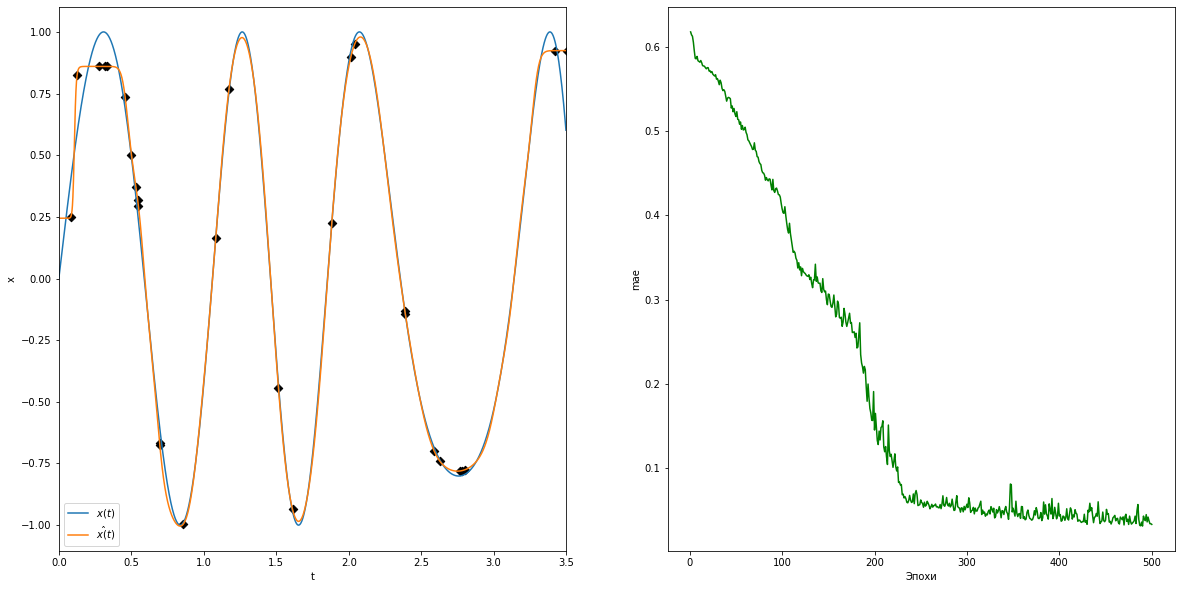

In [15]:
valid_x = np.arange(0, 3.5, h / 10)
valid_y = x(valid_x)

figure = plt.figure(figsize = (20, 10))

axes = figure.add_subplot(121)
plt.plot(valid_x, valid_y, label = "$x(t)$")
plt.plot(valid_x, model.predict(valid_x), label = "$x\^(t)$")
mu = model.get_layer("rbf_layer_gen").get_weights()[0][0]
plt.scatter(mu, model.predict(mu), color = "black", marker = "D")
plt.xlim(0, 3.5)
plt.ylabel("x")
plt.xlabel("t")
plt.legend()

axes = figure.add_subplot(122)
epticks = [(i + 1) for i in range(len(hst.history["mae"]))]
plt.plot(epticks, hst.history["mae"], "g")
plt.ylabel("mae")
plt.xlabel("Эпохи")

plt.show()

### Вывод

В ходе выполнения лабораторной работы я ознакомился с многослойными нейронными сетями, содержащими слои с радиальными базисными элементами. Реализовал две многослойные модели для решения задач классификации и апроскимации.